In [1]:
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

2025-05-15 23:15:50.115670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747350950.326875      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747350950.383110      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


ModuleNotFoundError: No module named 'sklearn.utils._metadata_requests'

In [53]:
FilePath = "/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv"
dataSet = pd.read_csv(FilePath)

In [54]:
# Extract labels (1D array) and features
Label = dataSet["label"]  # Correct: Series (1D)
Data = dataSet.drop(columns=["label"])  # Correct: DataFrame (2D)

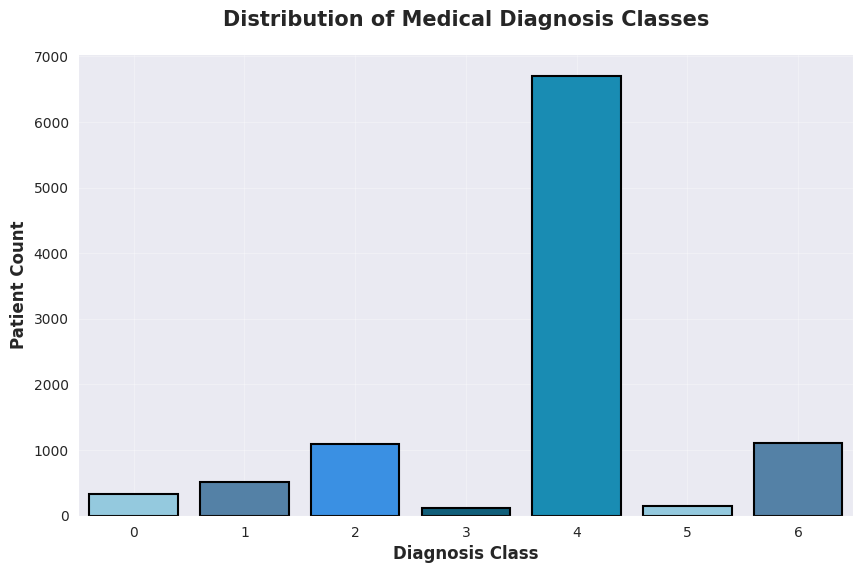

In [55]:
# Define medical-themed blues/sky colors
medical_palette = ["#87CEEB", "#4682B4", "#1E90FF", "#00688B", "#0099CC"]  # Sky blue → Deep sky blue → Steel blue → Darker blues

plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")

# Plot with custom palette
ax = sns.countplot(
    x=Label, 
    palette=medical_palette,  # Apply custom colors
    edgecolor="black",         # Add edge contrast
    linewidth=1.5
)

# Add annotations and style
plt.xlabel("Diagnosis Class", fontsize=12, weight="bold")  # Medical-themed label
plt.ylabel("Patient Count", fontsize=12, weight="bold")
plt.title("Distribution of Medical Diagnosis Classes", fontsize=15, pad=20, weight="bold")

# Customize grid and ticks
ax.grid(alpha=0.3)  # Soften grid lines
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [75]:
# Convert to NumPy arrays
Data = dataSet.drop(columns=["label"]).values  # Shape: (n, 2352)
Label = dataSet["label"].values                # Shape: (n,)

# Oversample
oversample = RandomOverSampler()
Data_resampled, Label_resampled = oversample.fit_resample(Data, Label)

# Reshape to images (28x28x3)
Data_reshaped = Data_resampled.reshape(-1, 28, 28, 3)

print("Reshaped Data:", Data_reshaped.shape)  # (new_samples, 28, 28, 3)
print("Resampled Labels:", Label_resampled.shape)  # (new_samples,)

Reshaped Data: (46935, 28, 28, 3)
Resampled Labels: (46935,)


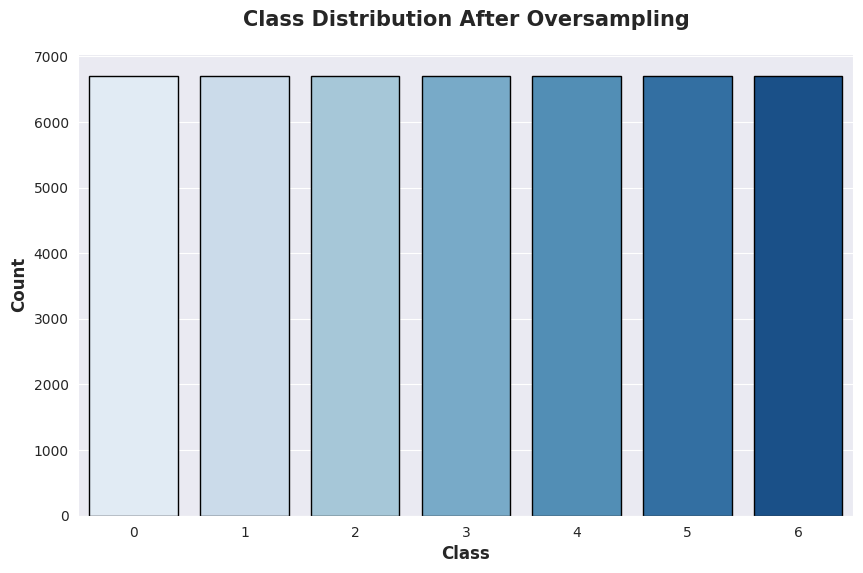

In [76]:
# Plot the new label distribution after oversampling
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
sns.countplot(x=Label_resampled, palette="Blues", edgecolor="black")
plt.xlabel("Class", fontsize=12, weight="bold")
plt.ylabel("Count", fontsize=12, weight="bold")
plt.title("Class Distribution After Oversampling", fontsize=15, pad=20, weight="bold")
plt.show()

In [77]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 0, 0, 6])

In [78]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

In [80]:
X_train , X_test , y_train , y_test = train_test_split(Data_reshaped , Label_resampled , test_size = 0.25 , random_state = 49)

In [81]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(35201, 28, 28, 3)
(11734, 28, 28, 3)
(35201,)
(11734,)


/tmp/ipykernel_35/2195705186.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


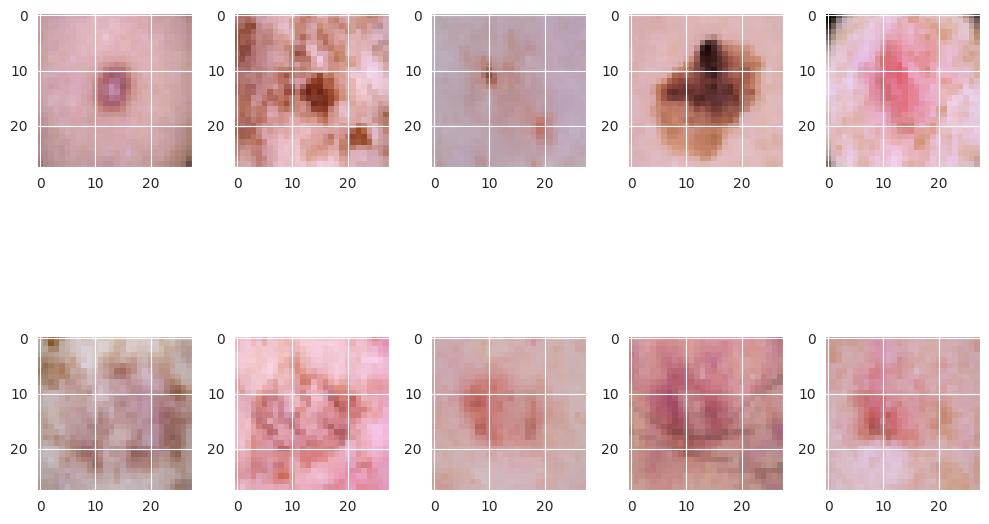

In [83]:
f , ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0 
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(X_train[k].reshape(28,28,3))
        k = k + 1
    plt.tight_layout()

In [84]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [85]:
print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [86]:
datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=10
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)
testgen = ImageDataGenerator(rescale=(1./255))

In [87]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

In [88]:
def My_Model():
    # Input layer
    input_ = keras.layers.Input(shape=[28, 28, 3])
    
    # First block - special case with single Conv2D
    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(input_)
    x = keras.layers.MaxPooling2D()(x)
    x = keras.layers.BatchNormalization()(x)
    
    # Remaining convolutional blocks with double Conv2D
    for filters in [64, 128, 256]:
        # Two conv layers with same parameters
        for _ in range(2):
            x = keras.layers.Conv2D(filters, (3, 3), activation='relu', 
                                  padding='same', kernel_initializer='he_normal')(x)
        x = keras.layers.MaxPooling2D()(x)
        x = keras.layers.BatchNormalization()(x)
    
    # Flatten and add dropout
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(rate=0.2)(x)
    
    # Dense layers (256, 128, 64)
    for units in [256, 128, 64]:
        x = keras.layers.Dense(units=units, activation='relu', kernel_initializer='he_normal')(x)
        x = keras.layers.BatchNormalization()(x)
    
    # Special case: 32-unit dense layer with L1L2 regularization
    x = keras.layers.Dense(units=32, activation='relu', kernel_initializer='he_normal',
                         kernel_regularizer=keras.regularizers.L1L2())(x)
    x = keras.layers.BatchNormalization()(x)
    
    # Output layer
    output = keras.layers.Dense(units=7, activation='softmax', 
                              kernel_initializer='glorot_uniform', name='classifier')(x)
    
    return keras.models.Model(inputs=input_, outputs=output)

In [89]:
model = My_Model()

In [90]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 28, 28, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_63               │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_64               │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_65               │ (None, 3, 3, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 3, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (None, 3, 3, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_66               │ (None, 1, 1, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,276,103 (4.87 MB)

 Trainable params: 1,274,183 (4.86 MB)

 Non-trainable params: 1,920 (7.50 KB)

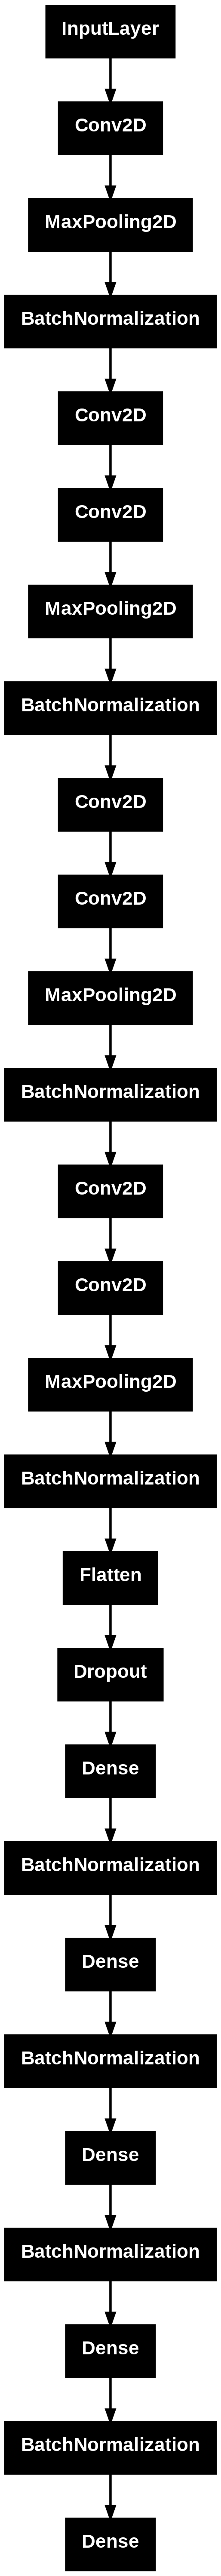

In [91]:
keras.utils.plot_model(model)

In [92]:
model.compile(optimizer='adam' , loss = keras.losses.CategoricalCrossentropy() ,metrics = ['accuracy'])

In [94]:
# 4. Reshape to 28x28x3
# X_train = X_train.reshape(-1, 28, 28, 3)
# X_test = X_test.reshape(-1, 28, 28, 3)

# 5. Train the model
model = My_Model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=25, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/25


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 7), output.shape=(None, 7)